# Model Selection and Comparison

## Table of contents

1. Original XGBoost
2. Simplified XGBoost
3. Another XGBoost
4. Yet Another XGBoost
5. Combining Models
6. Result Summary

主要參考 [Kaggle Kernel feature-engineering-xgboost](https://www.kaggle.com/dhimananubhav/feature-engineering-xgboost)

In [1]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import sys
import gc
import pickle

In [2]:
test  = pd.read_csv('dataset/test.csv').set_index('ID')

## 1. Original XGBoost

Use the original settings of XGBoost in the kernel

### Feature selection

In [41]:
all_data = pd.read_pickle('data.pkl')
data = all_data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

### Validation set is month 33

In [42]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [43]:
del all_data
gc.collect();

### XGBoost Model

In [44]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=6,
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

/home/robin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/robin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.15123	validation_1-rmse:1.11693
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10717	validation_1-rmse:1.08394
[2]	validation_0-rmse:1.06633	validation_1-rmse:1.05303
[3]	validation_0-rmse:1.03158	validation_1-rmse:1.02734
[4]	validation_0-rmse:1.00474	validation_1-rmse:1.0085
[5]	validation_0-rmse:0.979658	validation_1-rmse:0.990054
[6]	validation_0-rmse:0.958644	validation_1-rmse:0.975098
[7]	validation_0-rmse:0.939303	validation_1-rmse:0.961276
[8]	validation_0-rmse:0.924121	validation_1-rmse:0.951114
[9]	validation_0-rmse:0.911588	validation_1-rmse:0.943141
[10]	validation_0-rmse:0.90044	validation_1-rmse:0.936334
[11]	validation_0-rmse:0.890925	validation_1-rmse:0.930843
[12]	validation_0-rmse:0.883074	validation_1-rmse:0.926563
[13]	validation_0-rmse:0.876463	validation_1-rmse:0.923281
[14]	validation_0-rmse:0.870235	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
       nthread=6, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [45]:
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_orig.csv', index=False)

### Score 

0.91946

和作者原本的結果並不一樣（0.90646）

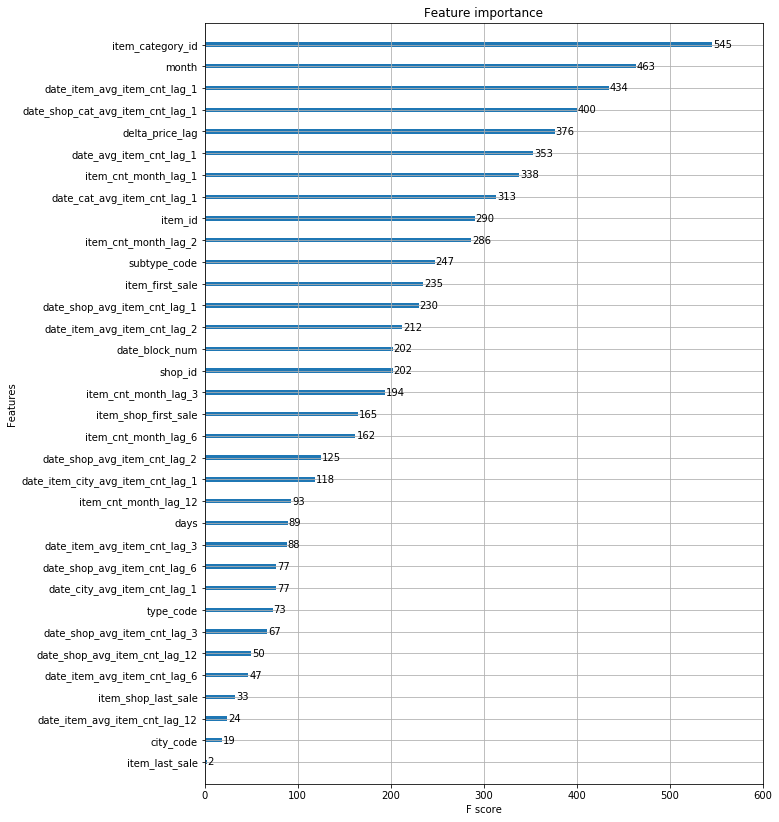

In [19]:
plot_features(model, (10,14))

## 2. Simplified XGBoost

去除 importance < 200 的 feature

In [15]:
all_data = pd.read_pickle('data.pkl')
data = all_data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    #'city_code',
    'item_category_id',
    #'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    #'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    #'date_item_avg_item_cnt_lag_6',
    #'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    #'date_shop_avg_item_cnt_lag_3',
    #'date_shop_avg_item_cnt_lag_6',
    #'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    #'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    #'item_shop_last_sale',
    #'item_last_sale',
    #'item_shop_first_sale',
    'item_first_sale',
]]

In [16]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [17]:
del all_data
gc.collect();

In [18]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=6,
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

/home/robin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/robin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.15308	validation_1-rmse:1.11883
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10545	validation_1-rmse:1.08119
[2]	validation_0-rmse:1.06865	validation_1-rmse:1.05441
[3]	validation_0-rmse:1.03372	validation_1-rmse:1.02898
[4]	validation_0-rmse:1.00403	validation_1-rmse:1.00723
[5]	validation_0-rmse:0.979266	validation_1-rmse:0.989493
[6]	validation_0-rmse:0.9594	validation_1-rmse:0.975342
[7]	validation_0-rmse:0.941923	validation_1-rmse:0.964545
[8]	validation_0-rmse:0.92745	validation_1-rmse:0.954641
[9]	validation_0-rmse:0.91542	validation_1-rmse:0.947145
[10]	validation_0-rmse:0.905351	validation_1-rmse:0.941181
[11]	validation_0-rmse:0.894913	validation_1-rmse:0.934839
[12]	validation_0-rmse:0.886822	validation_1-rmse:0.930361
[13]	validation_0-rmse:0.880489	validation_1-rmse:0.927572
[14]	validation_0-rmse:0.873678	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
       nthread=6, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [20]:
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_simple.csv', index=False)

### Score 

0.92180

## 3. Another XGBoost Model

In [21]:
all_data = pd.read_pickle('data.pkl')
data = all_data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    #'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    #'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    #'date_item_avg_item_cnt_lag_12',
    #'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    #'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    #'date_city_avg_item_cnt_lag_1',
    #'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [22]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [29]:
del all_data
gc.collect();

In [24]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1100,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=8,
    eta=0.4,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

/home/robin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/robin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.15937	validation_1-rmse:1.12239
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1112	validation_1-rmse:1.08447
[2]	validation_0-rmse:1.07113	validation_1-rmse:1.05547
[3]	validation_0-rmse:1.03583	validation_1-rmse:1.03002
[4]	validation_0-rmse:1.00857	validation_1-rmse:1.01076
[5]	validation_0-rmse:0.984167	validation_1-rmse:0.993591
[6]	validation_0-rmse:0.962345	validation_1-rmse:0.976874
[7]	validation_0-rmse:0.946804	validation_1-rmse:0.966845
[8]	validation_0-rmse:0.932867	validation_1-rmse:0.957481
[9]	validation_0-rmse:0.918487	validation_1-rmse:0.948516
[10]	validation_0-rmse:0.906417	validation_1-rmse:0.940499
[11]	validation_0-rmse:0.89653	validation_1-rmse:0.934549
[12]	validation_0-rmse:0.888435	validation_1-rmse:0.929693
[13]	validation_0-rmse:0.880893	validation_1-rmse:0.9263
[14]	validation_0-rmse:0.87476	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.4, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1100, n_jobs=1,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [25]:
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_another.csv', index=False)

### Score 

0.92481

## 4. Yet another XGBoost Model

In [3]:
all_data = pd.read_pickle('data.pkl')

In [4]:
data = all_data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
#     'date_avg_item_cnt_lag_1',
#     #'date_item_avg_item_cnt_lag_1',
#     'date_item_avg_item_cnt_lag_2',
#     'date_item_avg_item_cnt_lag_3',
#     'date_item_avg_item_cnt_lag_6',
#     #'date_item_avg_item_cnt_lag_12',
#     #'date_shop_avg_item_cnt_lag_1',
#     'date_shop_avg_item_cnt_lag_2',
#     'date_shop_avg_item_cnt_lag_3',
#     'date_shop_avg_item_cnt_lag_6',
#     #'date_shop_avg_item_cnt_lag_12',
#     'date_cat_avg_item_cnt_lag_1',
#     'date_shop_cat_avg_item_cnt_lag_1',
#     #'date_shop_type_avg_item_cnt_lag_1',
#     #'date_shop_subtype_avg_item_cnt_lag_1',
#     #'date_city_avg_item_cnt_lag_1',
#     #'date_item_city_avg_item_cnt_lag_1',
#     #'date_type_avg_item_cnt_lag_1',
#     #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
del data
gc.collect();

In [7]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,  
    nthread=8,
    seed=40)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

/home/robin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/robin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.15389	validation_1-rmse:1.11942
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10856	validation_1-rmse:1.08369
[2]	validation_0-rmse:1.06889	validation_1-rmse:1.0531
[3]	validation_0-rmse:1.03885	validation_1-rmse:1.03198
[4]	validation_0-rmse:1.01346	validation_1-rmse:1.01461
[5]	validation_0-rmse:0.99191	validation_1-rmse:0.998425
[6]	validation_0-rmse:0.969723	validation_1-rmse:0.982163
[7]	validation_0-rmse:0.951367	validation_1-rmse:0.969082
[8]	validation_0-rmse:0.935517	validation_1-rmse:0.958106
[9]	validation_0-rmse:0.922334	validation_1-rmse:0.949642
[10]	validation_0-rmse:0.911593	validation_1-rmse:0.943017
[11]	validation_0-rmse:0.902384	validation_1-rmse:0.937546
[12]	validation_0-rmse:0.894541	validation_1-rmse:0.93323
[13]	validation_0-rmse:0.888532	validation_1-rmse:0.930277
[14]	validation_0-rmse:0.883487	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=40, silent=True,
       subsample=0.8)

In [8]:
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_yet_another.csv', index=False)

### Score 

0.90987

## 5. Combining Models

對四個 Model 的結果進行平均

In [10]:
# Original Author's submission file
model0 = pd.read_csv('xgb_submission_author.csv')

model1 = pd.read_csv('xgb_submission_orig.csv')
model2 = pd.read_csv('xgb_submission_simple.csv')
model3 = pd.read_csv('xgb_submission_another.csv')
model4 = pd.read_csv('xgb_submission_yet_another.csv')

### Mean of 4 Models

In [17]:
mean = model1.item_cnt_month + model2.item_cnt_month + model3.item_cnt_month + model4.item_cnt_month 
mean /= 4

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": mean
})

In [18]:
submission.head()

,ID,item_cnt_month
0,0,0.805874
1,1,0.444560
2,2,1.412118
3,3,0.472407
4,4,3.476897


In [19]:
submission.to_csv('model_mean_4.csv', index=False)

#### Score

0.91293

### Mean of 2 Best Models

因爲 Model 0 和 Model 4 的 Validation Score 最高，優先考慮平均這兩個 Model

In [11]:
mean = model0.item_cnt_month + model4.item_cnt_month
mean /= 2

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": mean
})

submission.to_csv('model_mean_04.csv', index=False)

#### Score
0.90186

發現分數有很大的提升

### Different Weighted mean of model0 and model4

因爲單純平均就有 0.90186，進一步計算各種加權平均

In [12]:
weighted_mean = model0.item_cnt_month * 0.6 + model4.item_cnt_month * 0.4

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": weighted_mean
})

submission.to_csv('weighted_6_4_model_mean_04.csv', index=False)

#### Score 
0.90177

In [14]:
weighted_mean = model0.item_cnt_month * 0.7 + model4.item_cnt_month * 0.3

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": weighted_mean
})

submission.to_csv('weighted_7_3_model_mean_04.csv', index=False)

#### Score
0.90219

In [13]:
weighted_mean = model0.item_cnt_month * 0.4 + model4.item_cnt_month * 0.6

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": weighted_mean
})

submission.to_csv('weighted_4_6_model_mean_04.csv', index=False)

#### Score
0.90246

In [15]:
weighted_mean = model0.item_cnt_month * 0.8 + model4.item_cnt_month * 0.2

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": weighted_mean
})

submission.to_csv('weighted_8_2_model_mean_04.csv', index=False)

#### Score
0.90311

In [16]:
weighted_mean = model0.item_cnt_month * 0.55 + model4.item_cnt_month * 0.45

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": weighted_mean
})

submission.to_csv('weighted_55_45_model_mean_04.csv', index=False)

#### Score
0.90176

## 6. Result Summary

* Author's Result: 0.90646
* Orig XGBoost: 0.91946
* Simplified XGBoost: 0.92180
* Another XGBoost: 0.92481
* Yet Another XGBoost: 0.90987
* Mean of 4 models: 0.91293
* Mean of 2 best models: 0.90186
* Weight mean of 2 best models: 0.90176